# **<font color="purple"> Elaborato Automation - Giovanni Stefanini</font>**

## **Formation control con leader**

Supponiamo di avere un agente **leader** e **N** agenti che vogliono mantenere una certa formazione (es. poligono regolare) intorno al leader.

Il leader deve stare al centro della formazione. Gli altri agenti si dispongono in modo circolare intorno al leader, mantenendo la stessa distanza (raggio) uguale per tutti dal Leader e una certa distanza (che varia in base al numero di agenti) tra di loro. Quindi dovremo fissare la distanza dal leader, mentre tra gli agenti la distanza varierà in base al numero di agenti presenti. 

Supponiamo che l'obbiettivo del leader sia quello di andare verso un punto goal inizialmente fisso. Quindi solo il leader avrà un potenziale attrattivo verso il punto di goal. Da notare che sul leader non agirà nessun altro potenziale. 
Gli altri agenti dovranno avere un potenziale di formazione che li costringe a mantenere la formazione voluta, ma non subiscono il potenziale attrattivo del goal che subisce solo il leader.
Quindi i potenziali presenti devono essere:
- *Potenziale Attrattivo* che agisce sul leader e lo porta verso il goal.
- *Potenziale di Formazione* che agisce sugli agenti (non-leader) e che gli permette di mantenere la formazione.

Inizialmente si vuole un (punto) goal fisso, in seguito se il funzionamento è corretto si vuole muovere il goal in una direzione a caso e con velocità costante.

**Obbiettivo**: capire quale è la velocità massima che permette di mantenere la formazione. Ovvero vogliamo capire se c'è robustezza. 

**Nota**: il risultato atteso è che se il goal si muove troppo velocemente, non si riesca a mantenere la formazione.

**Consigli implementativi**: Fissare legge di controllo che funzioni per il caso base (ovvero goal fisso) e verificare se funziona anche nel caso con goal mobile.
Potenziali da utilizzare consigliati sono:
- *Potenziale Attrattivo* sul leader dovrà essere o quadratico o Huber-like. 
- *Potenziale di Formazione* sugli agenti dovrà essere potenziale dato dalla distanza.

La generazione degli agenti deve essere casuale ma comunque vicini tra loro e vicini al leader. Il punto di goal deve essere generato in modo casuale (ma questo può essere anche più distante rispetto a dove vengono generati gli agenti). Anche la direzione di movimento del goal dovrà essere casuale.
**Consiglio**: fissare una regione e poi generare uniformemente il leader in quella regione e in seguito utilizzare una gaussiana centrata nella posizione del leader per generare la posizione casuale degli agenti.

**Realizzazione**: realizzare un notebook python in cui si spiega tutti i passi fatti per realizzare l'implementazione e in cui è riportato il codice.

**Osservazioni finali**: ci sarà sicuramente da fare tuning per trovare i parametri ottimali dei potenziali.

--------------

## **Inizio elaborato assegnato**

### Librerie

Si inizia importanto le librerie `numpy`, `matplotlib.pyplot` e `matplotlib.animation`. Queste librerie sono utilizzate in Python per il calcolo scientifico e la visualizzazione dei dati.
Nello specifico:
- **NumPy** (abbreviazione di Numerical Python): È una libreria per fare calcoli scientifici in Python. Fornisce supporto per l'array multidimensionale, insieme a una vasta gamma di funzioni per operare su tali array. NumPy è estremamente efficiente nel manipolare grandi quantità di dati numerici e fornisce molte funzioni utili per l'analisi dati, l'algebra lineare e altro ancora.
- **Matplotlib**: È una libreria per la visualizzazione dei dati in Python. Matplotlib consente di creare grafici di alta qualità (matplotlib.pyplot) ma anche di creare delle gif animate (matplotlib.animation).

In questo contesto specifico, si utilizza NumPy per la gestione dei calcoli numerici e Matplotlib per visualizzare i risultati della simulazione tramite grafici e animazioni.

In [1]:
#import delle librerie utili
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

--------------

## **Agente**

In questa sezione si definisce la classe `Agent` che rappresenta gli agenti nel sistema considerato. La classe `Agent` ha due attributi, `position` e `velocity`, che rappresentano rispettivamente la posizione e la velocità dell'agente.

In [2]:
# Definire la classe `Agent` per rappresentare gli agenti nel sistema
class Agent:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity

#### Generazione Agenti

In questa sezione si vuole creare una funzione che generi gli agenti. La generazione della posizione degli agenti deve essere casuale ma comunque vicini tra loro. Nello specifico si vuole generare un 'leader' e poi generare più agenti 'semplici' che vengono generati casualmente vicino ad esso.  
Per farlo si fissa una regione e poi si genera con probabilità uniforme il leader in quella regione. In seguito si utilizza una probabilità gaussiana centrata nella posizione del leader per generare la posizione casuale degli altri agenti semplici.

Per realizzare quanto descritto, si procede nel seguente modo:
1. Generare casualmente la posizione del leader all'interno di una regione specificata.
2. Utilizzare una distribuzione gaussiana centrata sulla posizione del leader per generare le posizioni casuali degli altri agenti.
3. Creare gli oggetti `Agent` corrispondenti alle posizioni generate.

L'implementazione di questa logica in python, avviene tramite due funzioni separate per gestire la generazione del leader (`generate_leader`) e poi la generazione degli agenti (`generate_simple_agents`), nel modo seguente:

In [3]:
# Genera la posizione del leader all'interno di una certa regione con dimensioni decise da noi
def generate_leader(leader_region_center, leader_region_size):
    leader_position = np.random.uniform(
        leader_region_center - leader_region_size / 2,
        leader_region_center + leader_region_size / 2,
        size=2
    ) #random.uniform(low=, high=, size=) # low e high indicano che tutti i valori generati saranno nell'intervallo [low,high], shape = Forma di uscita
    return Agent(leader_position, np.zeros(2))  # Leader con velocità iniziale zero

# Genera gli agenti semplici con una distribuzione gaussiana centrata sul leader
def generate_simple_agents(num_simple_agents, leader_position, simple_agent_std_dev):
    simple_agents_positions = np.random.normal(
        leader_position,
        simple_agent_std_dev,
        size=(num_simple_agents, 2)
    )
    simple_agents = [Agent(position, np.zeros(2)) for position in simple_agents_positions]
    return simple_agents

Il parametro `leader_region_center` specifica il centro della regione dove verrà generato il leader, mentre `leader_region_size` indica la dimensione della regione. Infine, `simple_agent_std_dev` è la deviazione standard della distribuzione gaussiana utilizzata per generare le posizioni casuali degli agenti semplici rispetto alla posizione del leader.

Queste funzioni servono quindi per generare il leader e gli agenti semplici.

Di seguito si visualizza un esempio di utilizzo:

In [4]:
# Generazione Agenti in base a una regione in cui deve essere generato il leader
# Parametri di generazione
num_agents = 10  # Numero totale di agenti, incluso il leader
leader_region_center = np.array([5.0, 5.0])  # Centro della regione per il leader
leader_region_size = 2.0  # Dimensione della regione per il leader
simple_agent_std_dev = 0.5  # Deviazione standard per gli agenti semplici

# Generazione del leader
leader = generate_leader(leader_region_center, leader_region_size)

# Generazione degli agenti semplici
num_simple_agents = num_agents # - 1  # Se si esclude il leader dal conteggio totale
simple_agents = generate_simple_agents(num_simple_agents, leader.position, simple_agent_std_dev)

Questo fornirà un oggetto `Agent` che rappresentano il leader e una lista di oggetti `Agent` che rappresentano gli agenti semplici.

##### Visualizzazione Leader e Agenti

Adesso si visualizza la posizione dei vari agenti per verificare che il codice esegua quanto richiesto. Per farlo realizziamo la funzione `plot_agents` che prende in input la lista degli oggetti `Agent` (leader + agenti) e visualizza la posizione di tutti gli agenti su un grafico. Viene utilizzato un punto *rosso* per rappresentare il *leader* e punti *blu* per gli *agenti semplici*. Si può chiamare questa funzione per visualizzare la posizione di tutti gli agenti generati.

**NB** dobbiamo passare una lista combinata tra leader e agenti semplici per avere questo plot, con primo elemento il leader

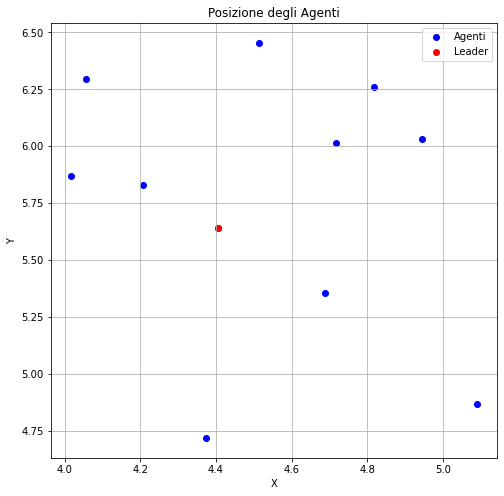

In [5]:
# Visualizza la posizione di tutti gli agenti in un grafico.
def plot_agents(agents):
    # Estrai le posizioni x e y di tutti gli agenti
    x_positions = [agent.position[0] for agent in agents]
    y_positions = [agent.position[1] for agent in agents]

    # Plot della posizione di tutti gli agenti
    plt.figure(figsize=(8, 8))
    plt.scatter(x_positions, y_positions, color='b', label='Agenti')
    
    # Plot della posizione del leader
    plt.scatter(x_positions[0], y_positions[0], color='r', label='Leader')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Posizione degli Agenti')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Combina leader e agenti semplici in una lista
agents = [leader] + simple_agents

# Utilizza la funzione plot_agents per visualizzare la posizione di tutti gli agenti
plot_agents(agents)

--------------

## **Goal**
Il goal sarà rappresentato da ***un punto nello spazio***. Inizialmente viene utilizzato un goal fisso e verificato che il sistema faccia quanto richiesto. Successivamente il goal si muoverà in una direzione fissa con una certa velocità costante. 

#### Generazione Goal

Adesso si vuole generare casualmente la posizione del goal in modo che sia abbastanza distante dalla posizione del leader.
Per ottenere questo risultato, si difinisce una funzione (`generate_goal_position`) che genera casualmente la posizione del goal all'interno di un'area di una certa dimensione, mantenendo una distanza minima dalla posizione del leader.

In [6]:
# Genera casualmente la posizione del goal in modo che sia abbastanza distante dalla posizione del leader
def generate_goal_position(leader_position, min_distance_from_leader, domain_size):

    # Genera casualmente la posizione del goal all'interno del dominio
    goal_position = np.random.uniform(0, domain_size, size=2)
    
    # Calcola la distanza tra il goal e il leader
    distance_to_leader = np.linalg.norm(goal_position - leader_position)
    
    # Se la distanza al leader è inferiore alla distanza minima desiderata,
    # sposta il goal in modo che sia abbastanza distante dal leader
    while distance_to_leader < min_distance_from_leader:
        goal_position = np.random.uniform(0, domain_size, size=2)
        distance_to_leader = np.linalg.norm(goal_position - leader_position)
    
    return goal_position # Restituisce la posizione del goal.

# Utilizza la funzione per generare la posizione del goal
goal_position = generate_goal_position(leader.position, min_distance_from_leader=5.0, domain_size=10.0)
print("Posizione del goal:", goal_position)

Posizione del goal: [0.76323452 9.51043436]


Questa funzione `generate_goal_position` genera casualmente la posizione del goal all'interno del dominio specificato. Se la distanza tra il goal e il leader è inferiore alla distanza minima desiderata, la funzione genera nuovamente la posizione del goal finché non viene soddisfatta la condizione di distanza desiderata. Questa funzione sarà utilizzata per ottenere la posizione del goal con la distanza desiderata dal leader.

##### Visualizzazione posizione Agenti e posizione Goal

Adesso si visualizza la posizione del goal e dei vari agenti per verificare che il codice esegua quanto richiesto. Per farlo realizziamo la funzione `plot_agents_with_goal` che prende in input la lista degli oggetti `Agent` (leader + agenti) e la posizione del goal. In seguito visualizza in <font color="green">*verde*</font> la posizione del <font color="green">*goal*</font>, in <font color="red">*rosso*</font> il <font color="red">*leader*</font> e in <font color="blu">*blu*</font> gli <font color="blu">*agenti semplici*</font>. Si può chiamare questa funzione per visualizzare la posizione di tutti gli agenti generati e del goal.

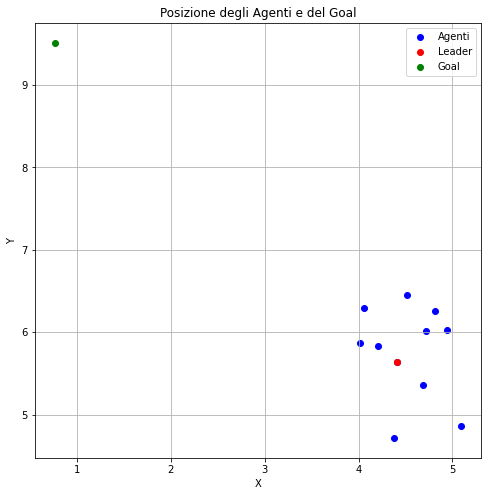

In [7]:
# Visualizza la posizione di tutti gli agenti e del goal in un grafico
def plot_agents_with_goal(agents, goal_position):
    
    # Estrai le posizioni x e y di tutti gli agenti
    x_positions = [agent.position[0] for agent in agents]
    y_positions = [agent.position[1] for agent in agents]

    # Plot della posizione di tutti gli agenti
    plt.figure(figsize=(8, 8))
    plt.scatter(x_positions, y_positions, color='b', label='Agenti')
    
    # Plot della posizione del leader
    plt.scatter(x_positions[0], y_positions[0], color='r', label='Leader')
    
    # Plot della posizione del goal
    plt.scatter(goal_position[0], goal_position[1], color='g', label='Goal')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Posizione degli Agenti e del Goal')
    plt.legend()
    plt.grid(True)
    plt.show()

# Combina leader e agenti semplici in una lista
# agents = [leader] + simple_agents

# Utilizza la funzione per visualizzare la posizione di tutti gli agenti e del goal
plot_agents_with_goal(agents, goal_position)

--------------

## **<font color="red">Potenziale Attrattivo sul Leader</font>**

Per implementare il ***potenziale*** attrattivo quadratico che agisce sul leader e lo avvicina al goal, si definisce una funzione (`attractive_potential`) che calcoli questo potenziale.

La formula matematica utilizzata per il potenziale attrattivo (quadratico) $J_{\text{attrattivo}}$ tra due punti $\mathbf{p}_{\text{leader}} $ e $\mathbf{p}_{\text{goal}} $ è definito come:

$J_{\text{attrattivo}}(\mathbf{p}_{\text{leader}}, \mathbf{p}_{\text{goal}}) = \frac{1}{2} k_{\text{attraction}} ||\mathbf{p}_{\text{leader}} - \mathbf{p}_{\text{goal}}||^2 $

Dove:
- $k_{\text{attraction}}$ è una costante che regola l'intensità del potenziale attrattivo,
- $\mathbf{p}_{\text{leader}}$ è la posizione del leader,
- $\mathbf{p}_{\text{goal}}$ è la posizione del goal,
- $||\mathbf{p}_{\text{leader}} - \mathbf{p}_{\text{goal}}||$ rappresenta la distanza euclidea tra $\mathbf{p}_{\text{leader}} $  e $\mathbf{p}_{\text{goal}} $.

Questo potenziale crea un'attrazione tra il leader e il goal, aumentando all'aumentare della distanza tra di loro.

Di seguito l'implementazione in python:

In [8]:
# Calcola il potenziale attrattivo (quadratico) tra il leader e il goal
def attractive_potential(leader_position, goal_position, k_attraction):
    distance_to_goal = np.linalg.norm(leader_position - goal_position) #calcola la norma euclidea della distanza tra Pleader e Pgoal
    return 0.5 * k_attraction * distance_to_goal ** 2 #calcola il valore del potenziale attrattivo secondo la formula precedente

### Forza Attrattiva sul leader

Per ottenere la ***forza*** derivante dal potenziale attrattivo definito precedentemente, possiamo calcolare il gradiente negativo del potenziale. Il gradiente di una funzione scalare è un vettore che punta nella direzione in cui la funzione cresce più rapidamente, e la sua magnitudine rappresenta il tasso di crescita della funzione in quella direzione. In questo caso, si vuole la direzione in cui il potenziale attrattivo diminuisce più rapidamente, quindi si prende il suo negativo.

Per il potenziale attrattivo che è stato precedentemente definito si ha che il gradiente è:

$
\nabla J_{attrattivo} = -k_{attr} (\mathbf{p}_{goal} - \mathbf{p}_{leader})
$

dove:
- $ \nabla J_{attrattivo} $ rappresenta il gradiente del potenziale attrattivo,
- $ k_{attr} $ è la costante di attrazione,
- $ \mathbf{p}_{leader} $ è la posizione del leader, e
- $ \mathbf{p}_{goal} $ è la posizione del goal.

Quindi, per ottenere la forza, è sufficiente prendere il gradiente negativo del potenziale attrattivo:

$
\text{Forza}_{attrattiva} = k_{attr} (\mathbf{p}_{goal} - \mathbf{p}_{leader}) = - \nabla J_{attrattivo}
$

In questo modo, si ottiene un vettore che indica la direzione e l'intensità della forza che spinge il leader verso il goal. Questo vettore di forza può quindi essere utilizzato per muovere il leader nella simulazione.

In [9]:
# Funzione per calcolare la forza attrattiva (gradiente negativo del potenziale)
def calculate_attraction_force(leader_position, goal_position, k_attraction):
    return -k_attraction * (leader_position - goal_position)

Si può quindi utilizzare la funzione `calculate_attraction_force` per calcolare la forza agente che agisce sul leader e lo avvicina al goal, piuttosto che usare il potenziale attrattivo.

Notare che la _direzione della forza attrattiva_ è opposta a quella del gradiente del potenziale attrattivo. In altre parole, la forza attrattiva punta nella direzione in cui il potenziale attrattivo diminuisce più rapidamente. Questo significa che la forza attrattiva spingerà il leader verso il goal.

#### Effetto forza attrattiva sul Leader

Per visualizzare l'effetto della forza attrattiva sul leader e osservare cosa succede nel tempo con un'animazione, sono stati seguiti i seguenti passaggi:

1. Calcolata la forza attrattiva applicata al leader utilizzando il potenziale attrattivo quadratico.
2. Aggiornato la posizione del leader in base alla velocità che viene calcolata utilizzando la forza.
3. Ripetuti i passaggi 1 e 2 per ogni frame dell'animazione.

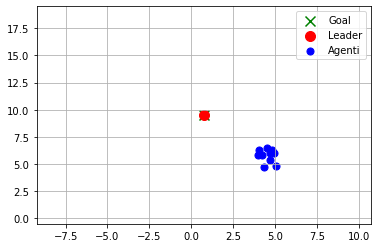

In [10]:
# Parametri del sistema
k_attraction = 0.125  # Costante che regola l'intensità del potenziale attrattivo
mass = 1.0  # Massa del leader
delta_time = 0.5  # Passo temporale 
epsilon = 0.1  # Soglia per considerare il GOAL raggiunto
view_size = 20.0  # Dimensione della finestra visibile (distanza dal goal)

# Velocità del leader
velocity = np.array([0.0, 0.0])  # Velocità iniziale

# Acquisizione posizione leader
leader_position = leader.position

# Funzione per aggiornare l'animazione
def update(frame):
    global leader_position, velocity

    # Calcola la forza di attrazione
    force = calculate_attraction_force(leader_position, goal_position, k_attraction)

    # Calcola l'accelerazione (F = m * a)
    acceleration = force / mass

    # Aggiorna la velocità (v = a * dt)
    velocity = acceleration * delta_time 

    # Aggiorna la posizione (x = x + v * dt)
    leader_position += velocity * delta_time

    # Aggiorna il grafico del leader
    sc_leader.set_offsets(leader_position)
    
    # Mantieni visibili gli altri agenti (che non si muovono)
    other_agents_positions = [agent.position for agent in agents[1:]] 
    sc_agents.set_offsets(other_agents_positions)

    # Centra gli assi attorno al goal
    ax.set_xlim(goal_position[0] - view_size / 2, goal_position[0] + view_size / 2)
    ax.set_ylim(goal_position[1] - view_size / 2, goal_position[1] + view_size / 2)

    # Termina l'animazione se il leader è sufficientemente vicino al goal
    if np.linalg.norm(leader_position - goal_position) < epsilon:
        ani.event_source.stop()

    return sc_leader,

# Inizializza il plot
fig, ax = plt.subplots()
sc_goal = ax.scatter(goal_position[0], goal_position[1], color='g', label='Goal', s=100, marker='x') #s = marker size
sc_leader = ax.scatter(leader_position[0], leader_position[1], color='r', label='Leader', s=100)

# Visualizza gli altri agenti
other_agents_positions = [agent.position for agent in agents[1:]]  # Escludi il leader
sc_agents = ax.scatter([pos[0] for pos in other_agents_positions], [pos[1] for pos in other_agents_positions], color='b', label='Agenti', s=50)

# Configura gli assi iniziali
ax.legend()
ax.grid(True)
ax.set_xlim(goal_position[0] - view_size / 2, goal_position[0] + view_size / 2)
ax.set_ylim(goal_position[1] - view_size / 2, goal_position[1] + view_size / 2)

# Crea e salva l'animazione
ani = FuncAnimation(fig, update, frames=200, interval=20)
ani.save('leader_to_goal.gif', dpi=100, fps=30, writer='pillow')
plt.show()

--------------

## **<font color="blue">Potenziale di Formazione sugli agenti</font>**

Per definire il potenziale di formazione che permette agli agenti semplici di disporsi in modo circolare intorno al leader (quindi rimanere a una determinata distanza dal leader) e mantenere la stessa distanza tra di loro, si utilizza una funzione potenziale basata sulla distanza tra gli agenti e la posizione target che devono raggiungere.

### Potenziale di formazione sugli agenti

Funzione potenziale che può essere usata è la seguente:

$$ J_{\text{formazionecomplessivo}} = \sum_{i=1}^{N} \frac{1}{2} k_{\text{formation}} \| \mathbf{p}_{target} - \mathbf{p}_i \| ^2 $$

Dove:
- $N$: numero di agenti.
- $k_{\text{formation}}$: costante che regola l'intensità del potenziale di formazione.
- $p_{\text{target}}$: posizione desiderata degli agenti.
- $p_{\text{i}}$: posizione dell'agente i.

**NB**. quello nella formula sarà il potenziale complessivo di formazione.

### Potenziale formazione per un singolo agente $i$

Il _potenziale totale_ per un singolo agente $i$ è quindi dato da:

$ J_{\text{formazione}, i} = \frac{1}{2} k_{\text{formation}} \| \mathbf{p}_{target} - \mathbf{p}_{agente} \| ^2  $

Dove il $p_{\text{agente}}$ è la posizione dell'agente.

### Forza Formazione su singolo Agente

Per calcolare la forza che agisce su un singolo agente, si può utilizzare il gradiente del potenziale rispetto alla posizione dell'agente. Come già indicato il gradiente del potenziale è una quantità vettoriale che punta nella direzione in cui il potenziale aumenta più rapidamente e la sua magnitudine indica la pendenza del potenziale lungo quella direzione. Come nel caso precedente, otteniamo la forza che agisce sull'agente come il negativo di questo vettore gradiente:

$
\text{Forza}_{formazione} = - \nabla J_{formazione}
$

Quindi _per ogni singolo agente_ agisce una _unica forza che spinge l'agente a posizionarsi nella posizione corretta_ intorno al leader in base anche alla presenza degli altri agenti. Di seguito viene implemementato quanto teorizzato.

#### Distanza tra Agenti Semplici

Per disporre gli agenti in modo che siano equidistanti su una circonferenza attorno al leader, si può utilizzare la geometria circolare. Seguendo questi passi:

1. **_Punto centrale_**: Il leader rappresenta il centro della circonferenza.
2. **_Raggio_**: La distanza degli agenti dal leader ($d_{\text{target}}$) è il raggio della circonferenza.
3. **_Distribuzione uniforme_**: Per disporre \(N\) agenti equidistanti, si deve dividere la circonferenza in \(N\) angoli uguali. L'angolo tra due agenti consecutivi è dato da $(\frac{2\pi}{N}$).
4. **_Coordinate polari_**: Usando le coordinate polari, si può calcolare le posizioni di ciascun agente con:
   - $( x = x_{\text{leader}} + r \cdot \cos(\theta) )$
   - $( y = y_{\text{leader}} + r \cdot \sin(\theta) )$
   dove $( r )$ è il raggio e $( \theta )$ varia in incrementi di $( \frac{2\pi}{N} )$.
   
Questo servirà per trovare il $p_{target}$ che deve raggiungere ogni singolo agente.

Per fare in modo che gli agenti si posizionino in cerchio intorno al leader si utilizza la funzione `distribute_agents_in_circle`. Le posizioni degli agenti restituite da questa funzione verranno considerate come **posizioni goal** per ciascun agente.

In [11]:
# Funzione per distribuire gli agenti in cerchio
def distribute_agents_in_circle(leader_position, num_agents, radius):
    agents_positions = []
    angle_step = 2 * np.pi / num_agents  # Angolo tra due agenti consecutivi

    for i in range(num_agents):
        theta = i * angle_step
        x = leader_position[0] + radius * np.cos(theta)
        y = leader_position[1] + radius * np.sin(theta)
        agents_positions.append((x, y))

    return agents_positions

La funzione `distribute_agents_in_circle` genera le posizioni goal distribuite equamente su una circonferenza attorno al leader, ovvero distribuisce gli agenti in cerchio intorno al leader.

#### Aggiornamento classe Agent

Si aggiorna la classe `Agent` (agente) al fine di poter includere una posizione goal (`goal_position`) all'interno della formazione (punto in cui devono stare nella formazione). Questo ci aiuterà nell'esecuzione del codice.

In [12]:
# Classe Agent aggiornata per includere la posizione goal
class Agent:
    def __init__(self, position, velocity, goal_position=None):
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        self.goal_position = np.array(goal_position) if goal_position is not None else None

#### Calcolo Forza di Formazione

Per realizzare il codice che calcola la forza di formazione, possiamo seguire una procedura simile a quella utilizzata per la forza attrattiva sul leader. Tuttavia, anziché spostare il leader verso un obiettivo, si sposta gli agenti per raggiungere la formazione desiderata.
Quindi, si calcolerà la **forza di formazione** che avvicina gli agenti alla loro posizione goal corretta nella formazione.

In [13]:
# Funzione per calcolare la forza attrattiva verso il goal (rinominata)
def calculate_formation_force(agent_position, goal_position, k_formation):
    return -k_formation * (agent_position - goal_position)

Inoltre per far sì che ogni agente si collochi nella **posizione goal** più vicina alla propria posizione iniziale, si può aggiungere una logica per assegnare ogni posizione goal a un agente, minimizzando la distanza tra la posizione iniziale dell'agente e la posizione goal.
Questo può essere realizzato utilizzando un algoritmo che associa ogni agente alla posizione goal più vicina, evitando sovrapposizioni. Una soluzione efficace è l'uso di un **algoritmo greedy** (che minimizza il percorso).

Codice algoritmo greedy:

In [14]:
# Funzione per assegnare le posizioni goal agli agenti minimizzando la distanza
def assign_goals_to_agents(agents, goal_positions):
    unassigned_goals = goal_positions.copy()  # Copia delle posizioni goal ancora disponibili

    for agent in agents:
        # Trova la posizione goal più vicina all'agente
        distances = [np.linalg.norm(agent.position - goal) for goal in unassigned_goals]
        nearest_goal_idx = np.argmin(distances)
        agent.goal_position = unassigned_goals.pop(nearest_goal_idx)  # Assegna e rimuovi la goal assegnata

La funzione `assign_goals_to_agents` assegna ogni agente alla posizione goal più vicina. Per ogni agente, calcola la distanza rispetto a tutte le posizioni goal disponibili. Assegna la posizione più vicina e la rimuove dalla lista di posizioni goal ancora disponibili.

Di seguito è implemento un codice che realizza un'animazione in cui ogni agente si muove verso la propria posizione obiettivo:

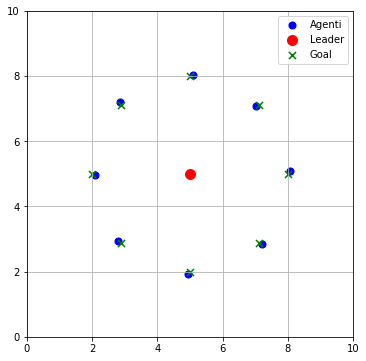

In [15]:
# Parametri
leader_position = (5.0, 5.0) # Posizione del leader
num_agents = 8 # Numero di agenti
radius = 3.0 # Distanza dal leader (raggio)
k_formation = 0.5 # Costante attrattiva per il movimento
mass = 1.0 # Massa degli agenti
delta_time = 0.5 # Passo temporale
epsilon_agents = 0.1 # Soglia per considerare un goal raggiunto (agente nella posizione corretta)

# Genera le posizioni goal
goal_positions = distribute_agents_in_circle(leader_position, num_agents, radius)

# Inizializza gli agenti in posizioni casuali
agents = [Agent(position=np.random.uniform(0, 10, size=2), velocity=np.zeros(2)) 
          for _ in range(num_agents)]

# Assegna le posizioni goal agli agenti
assign_goals_to_agents(agents, goal_positions)

# Funzione per aggiornare le posizioni degli agenti nell'animazione
def update(frame):
    global agents

    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso il goal
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass  # F = ma
            agent.velocity = acceleration * delta_time #agent.velocity += acceleration * delta_time  # v = v + a * dt # probabilmente il v precedente non ci deve essere
            agent.position += agent.velocity * delta_time  # x = x + v * dt

            # Se l'agente raggiunge il goal, ferma il movimento
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)  # Ferma l'agente
                agent.goal_position = None  # Goal raggiunto

    # Aggiorna i dati di visualizzazione
    sc_agents.set_offsets([agent.position for agent in agents])
    return sc_agents,

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(6, 6))
sc_agents = ax.scatter([agent.position[0] for agent in agents],
                       [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)
ax.scatter([leader_position[0]], [leader_position[1]], color='r', label='Leader', s=100)
ax.scatter([goal[0] for goal in goal_positions], 
           [goal[1] for goal in goal_positions], color='g', label='Goal', s=50, marker='x')

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione
ani = FuncAnimation(fig, update, frames=200, interval=50)
ani.save('agents_to_formation.gif', dpi=100, fps=30, writer='pillow')
plt.show()

In questo codice, dentro la funzione update, si ha:
- *Movimento verso il goal*: Per ogni agente, si calcola una forza attrattiva basata sulla distanza dal goal e degli altri agenti. Si aggiornano velocità e posizione utilizzando le equazioni del moto.
- *Condizione di arresto*: Quando un agente raggiunge il suo goal (distanza < `epsilon_agents`), la sua velocità viene azzerata, e il goal è considerato raggiunto.

--------------

## **<font color="green">Movimento verso _Goal Fisso_</font>**

In questa sezione, si vede come realizzare il movimento del Leader verso il _Goal Fisso_ e mantenere gli Agenti in formazione. Per farlo si unisce i codici precedenti in modo che:

1. Il **leader** si muova verso il proprio goal usando la logica di `calculate_attraction_force`.
2. Gli **altri agenti** aggiornino le loro posizioni relative al leader, mantenendo la formazione attorno al leader, usando la logica di `calculate_formation_force`.

Di seguito il codice unificato:

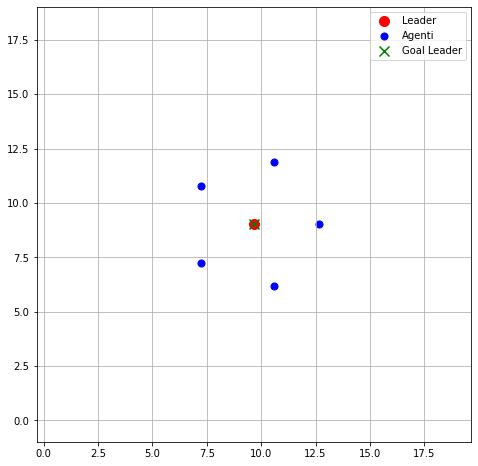

In [16]:
# --- Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal
k_formation = 0.5  # Costante per mantenere la formazione
mass = 1.0  # Massa degli agenti
delta_time = 0.5  # Passo temporale
epsilon_leader = 0.1 # Soglia per considerare un goal raggiunto (0.1)
epsilon_agents = 0.1 # Soglia per considerare una posizione raggiunta (0.1)
radius = 3.0  # Raggio della formazione
view_size = 20.0  # Dimensione della finestra visibile
min_distance_from_leader = 5.0 # Distanza minima del goal dal leader
domain_size = 10.0 # Dimensione del dominio di generazione del goal

# --- Generazione Agenti e Leader in base a una regione in cui deve essere generato il leader
leader_region_center = np.array([5.0, 5.0]) # Centro della regione fissa in cui deve essere generato il leader
leader_region_size = 2.0 # Dimensioni della regione fissa in cui deve essere generato il leader
simple_agent_std_dev = 0.5 # Deviazione standard della gaussiana che serve per generare gli agenti

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
num_agents = 5 # Numero totale di agenti semplici (escluso il leader)
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Funzione per aggiornare il sistema (leader + agenti) ad ogni frame
def update(frame):
    global leader, agents, goal_positions

    # --- Movimento del leader
    # Calcola la forza di attrazione verso il goal del leader
    force_leader = calculate_attraction_force(leader.position, goal_position, k_attraction)
    acceleration_leader = force_leader / mass
    leader.velocity = acceleration_leader * delta_time #leader.velocity += acceleration_leader * delta_time
    leader.position += leader.velocity * delta_time

    # --- Movimento degli agenti in formazione attorno al leader
    # Aggiorna le posizioni goal degli agenti in base alla nuova posizione del leader
    goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
    assign_goals_to_agents(agents, goal_positions)

    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso la posizione goal relativa
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass
            agent.velocity = acceleration * delta_time #agent.velocity += acceleration * delta_time
            agent.position += agent.velocity * delta_time

            # Controlla se l'agente ha raggiunto il goal
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)
                agent.goal_position = None

    # --- Aggiornamento della visualizzazione
    sc_leader.set_offsets(leader.position)  # Aggiorna la posizione del leader
    sc_agents.set_offsets([agent.position for agent in agents])  # Aggiorna la posizione degli agenti

    # Centra la vista attorno al leader
    ax.set_xlim(leader.position[0] - view_size / 2, leader.position[0] + view_size / 2)
    ax.set_ylim(leader.position[1] - view_size / 2, leader.position[1] + view_size / 2)

    # Termina l'animazione se il leader raggiunge il suo goal
    if np.linalg.norm(leader.position - goal_position) < epsilon_leader:
        leader.velocity = np.zeros(2)
        ani.event_source.stop()

    return sc_leader, sc_agents

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100) #stampa leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50) #stampa agenti
ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x') #stampa goal

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione
ani = FuncAnimation(fig, update, frames=300, interval=50) #frames=500, interval=50)
ani.save('fixed_goal.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Il leader si muove verso il proprio goal e gli agenti lo seguono mantenendo una formazione stabile attorno a lui. 

**NB** Il grafico mantiene il leader al centro della finestra visibile

--------------

## **<font color="green">Movimento verso _Goal Mobile_</font>**

In questa sezione, si vede come realizzare il movimento del Leader verso il _Goal Mobile_ e mantenere gli Agenti in formazione. Per farlo si prende il codice precedente e si aggiunge la logica per far muovere il Goal. Per fare in modo che il goal del leader si sposti a velocità costante in una direzione casuale durante l'animazione, si aggiorna la posizione del goal ad ogni frame attribuento al goal una certa velocità. Quindi si aggiunge un parametro per il movimento costante in una direzione casuale del goal, definendo una variabile che rappresenti l'intensità dello spostamento casuale del goal (`goal_speed`).

Per aggiornare la posizione del goal si usa la seguente funzione (`move_goal`): 

In [17]:
def move_goal(goal_position, goal_velocity):
    # Aggiorna la posizione del goal
    new_goal_position = goal_position + goal_velocity * delta_time
    return new_goal_position

Aggiornando il codice precedente con il movimento del goal otteniamo:

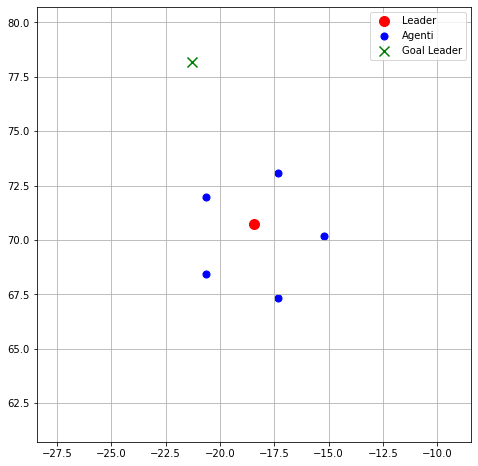

In [18]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal
k_formation = 1.25  # Costante per mantenere la formazione
mass = 1.0  # Massa degli agenti e leader
delta_time = 0.5  # Passo temporale
epsilon_leader = 0.1 # Soglia per considerare un goal raggiunto (0.1)
epsilon_agents = 0.1 # Soglia per considerare una posizione raggiunta (0.1)
radius = 3.0  # Raggio della formazione
view_size = 20.0  # Dimensione della finestra visibile
min_distance_from_leader = 5.0 # Distanza minima del goal dal leader
domain_size = 10.0 # Dimensione del dominio di generazione del goal

# --- Generazione Agenti e Leader in base a una regione in cui deve essere generato il leader
leader_region_center = np.array([5.0, 5.0]) # Centro della regione fissa in cui deve essere generato il leader
leader_region_size = 5.0 # Dimensioni della regione fissa in cui deve essere generato il leader
simple_agent_std_dev = 1.5 # Deviazione standard della gaussiana che serve per generare gli agenti

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
num_agents = 5 # Numero totale di agenti semplici (escluso il leader)
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Parametro per la velocità del goal
goal_speed = 0.5  # Velocità costante del goal ottimale: 0.5
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

# Funzione per aggiornare il sistema (leader + agenti) ad ogni frame
def update(frame):
    global leader, agents, goal_positions, goal_position, goal_velocity

    # Movimento del leader
    force_leader = calculate_attraction_force(leader.position, goal_position, k_attraction)
    acceleration_leader = force_leader / mass
    leader.velocity = acceleration_leader * delta_time 
    leader.position += leader.velocity * delta_time

    # Movimento del goal del leader
    goal_position = move_goal(goal_position, goal_velocity)

    # Movimento degli agenti in formazione attorno al leader
    goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
    assign_goals_to_agents(agents, goal_positions)
                
    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso la posizione goal relativa
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass
            agent.velocity = acceleration * delta_time #agent.velocity += acceleration * delta_time
            agent.position += agent.velocity * delta_time

            # Controlla se l'agente ha raggiunto il goal
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)
                agent.goal_position = None

    # Aggiorna la visualizzazione
    sc_leader.set_offsets(leader.position)
    sc_agents.set_offsets([agent.position for agent in agents])
    sc_goal.set_offsets(goal_position)

    ax.set_xlim(leader.position[0] - view_size / 2, leader.position[0] + view_size / 2)
    ax.set_ylim(leader.position[1] - view_size / 2, leader.position[1] + view_size / 2)

    if np.linalg.norm(leader.position - goal_position) < epsilon_leader:
        leader.velocity = np.zeros(2)
        ani.event_source.stop()

    return sc_leader, sc_agents, sc_goal

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione
ani = FuncAnimation(fig, update, frames=300, interval=50)  # frames=500, interval=50
ani.save('moving_goal.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel codice precedente si può notare che si ha:
- *Movimento costante del goal*: Ad ogni frame, il goal del leader si sposta in una direzione costante. Una volta calcolata la velocità iniziale, il goal si sposta linearmente lungo quella direzione.
- *Moviemnto del sistema di agenti*: Ad ogni frame, la formazione di agenti e il leader si muovono verso il goal che si sta spostando.

--------------

## **Parametri del sistema**

Per implementare i precedenti esperimenti i parametri importanti che sono stati considerati sono:

- **`k_attraction`** (Costante per l'attrazione del leader al suo goal): Serve per determinare la forza con cui il leader è attratto verso il suo obiettivo (goal). Un valore maggiore fa sì che il leader si muova più rapidamente verso il goal. 

- **`k_formation`** (Costante per mantenere la formazione): Serve per regolare la forza con cui gli agenti si posizionano attorno al leader mantenendo la formazione desiderata. Valori più alti fanno sì che gli agenti seguano più strettamente il leader, mentre valori bassi permettono movimenti più lenti e meno precisi.

- **`mass`** (Massa degli agenti e del leader): La massa viene usata per calcolare l'accelerazione degli oggetti in base alla forza applicata ($F = ma$). Influisce sulla reattività del movimento: una massa maggiore rende il sistema più lento e stabile. ***Nota***: è stata considerata pari a 1 in modo che potesse semplificare i calcoli e che potesse essere considerata trascurabile.

- **`delta_time`** (Passo temporale): Determina l'incremento temporale per ogni frame di simulazione. Valori più piccoli rendono la simulazione più precisa ma più lenta, mentre valori più grandi possono causare instabilità numeriche. ***Nota***: sono stati considerati valori diversi, ma quello che si combina meglio con i valori di k risulta essere un delta_time di 0.5.

- **`epsilon`** (Soglia per considerare un goal raggiunto): Serve per fermare l'agente nel caso in cui la distanza dal goal sia minore di una certa soglia. Di questa se ne considera due tipi diversi (***_Nota_***: dagli esperimenti è venuto fuori che una buona epsilon è data per entrambi da 0.1.):
   - **`epsilon_leader`:** Stabilisce la distanza minima tra il leader e il goal per considerare l'obiettivo raggiunto.
   - **`epsilon_agents`:** Stabilisce la distanza minima tra un agente e la sua posizione obiettivo all'interno della formazione.

- **`radius`** (Raggio della formazione): Indica la distanza a cui gli agenti devono disporsi rispetto al leader per mantenere la formazione circolare.

- **`num_agents`** (Numero totale di agenti semplici): Indica il numero di agenti che devono mantenere la formazione attorno al leader. ***Nota***: più aumentiamo questo valore e più il computer avrà calcoli da fare, ciò rallenterà l'esecuzione.

- **`goal_speed`** (Velocità costante del goal): Definisce la velocità con cui il goal del leader si muove nello spazio. 

Questi parametri insieme regolano il comportamento del leader, degli agenti e del goal. Alterare uno o più di essi consente di modificare la dinamica del sistema.
Negli esperimenti fino ad ora considerati i valori dei parametri sono stati i seguenti:
- k_attraction = 0.125 
- k_formation = 0.5 (fisso)  o 1.25 (mobile)
- mass = 1.0  
- delta_time = 0.5  
- epsilon_leader = 0.1 
- epsilon_agents = 0.1 
- radius = 3.0  
- num_agents = 5 
- goal_speed = 0.5  

#### **Rapporto tra $k_{attraction}$ e $k_{formation}$**

Dati i parametri del sistema precedentemente elencati, si nota che se si ha un certo `k_attraction`, per avere un `k_formation` che consente agli agenti di seguire in modo efficente il leader, si deve distinguere tra il caso in cui il Goal sia fisso e il caso in cui il Goal sia mobile:
- **Goal fisso**: il k_formation deve essere più grande di almeno 4 volte del k_attraction per avere un buon esperimento.
- **Goal mobile**: quando aggiungiamo il movimento del goal, il k_formation deve essere almeno 10 volte superiore al k_attraction per avere un buon esperimento.

Quindi il rapporto che abbiamo tra $k_{formation}$ e $k_{attraction}$, negli esperimenti finora condotti è di:
- $k_{formation} \approx 4 \times k_{attraction}$ per il ***Goal fisso***
- $k_{formation} \approx 10 \times k_{attraction}$ per il ***Goal mobile***

Questo assicura che gli agenti si "aggancino" rapidamente alla formazione ma senza disturbarla eccessivamente mentre il leader si muove.

**NB** Se si varia i parametri del sistema rispetto alla configurazione base presa per gli esperimenti, allora questi rapporti possono cambiare. Nello specifico più si aumenta il k_attraction e minore sarà il rapporto con il k_formation.

--------------

## **<font color="purple">Esperimenti e Studio della velocità massima</font>** 

Per trovare la velocità massima che il nostro sistema di agenti riesce a seguire correttamente secondo la nostra legge di controllo si fissa i seguenti parametri:
- k_attraction = 0.125 
- k_formation = 1.25
- mass = 1.0  
- delta_time = 0.5  
- epsilon_leader, epsilon_agents = 0.1 
- radius = 3.0  
- num_agents = 5 

In [19]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal 
k_formation = 1.25  # Costante per mantenere la formazione 
mass = 1.0  # Massa degli agenti e leader
delta_time = 0.5  # Passo temporale
epsilon_leader = 0.1 # Soglia per considerare un goal raggiunto (0.1)
epsilon_agents = 0.1 # Soglia per considerare una posizione raggiunta (0.1)
radius = 3.0  # Raggio della formazione
num_agents = 5 # Numero totale di agenti semplici (escluso il leader)

min_distance_from_leader = 5.0 # Distanza minima del goal dal leader
domain_size = 10.0 # Dimensione del dominio di generazione del goal

leader_region_center = np.array([5.0, 5.0]) # Centro della regione fissa in cui deve essere generato il leader
leader_region_size = 5.0 # Dimensioni della regione fissa in cui deve essere generato il leader
simple_agent_std_dev = 1.5 # Deviazione standard della gaussiana che serve per generare gli agenti

Inoltre verrà utilizzata la seguente funzione (`update`) per eseguire tutti i calcoli e generare l'animazione:

In [20]:
# Funzione per aggiornare il sistema (leader + agenti) ad ogni frame
def update(frame):
    global leader, agents, goal_positions, goal_position, goal_velocity

    # Movimento del leader
    force_leader = calculate_attraction_force(leader.position, goal_position, k_attraction)
    acceleration_leader = force_leader / mass
    leader.velocity = acceleration_leader * delta_time 
    leader.position += leader.velocity * delta_time

    # Movimento del goal del leader
    goal_position = move_goal(goal_position, goal_velocity)

    # Movimento degli agenti in formazione attorno al leader
    goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
    assign_goals_to_agents(agents, goal_positions)
                
    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso la posizione goal relativa
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass
            agent.velocity = acceleration * delta_time #agent.velocity += acceleration * delta_time
            agent.position += agent.velocity * delta_time

            # Controlla se l'agente ha raggiunto il goal
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)
                agent.goal_position = None

    # Aggiorna la visualizzazione
    sc_leader.set_offsets(leader.position)
    sc_agents.set_offsets([agent.position for agent in agents])
    sc_goal.set_offsets(goal_position)

    ax.set_xlim(leader.position[0] - view_size / 2, leader.position[0] + view_size / 2)
    ax.set_ylim(leader.position[1] - view_size / 2, leader.position[1] + view_size / 2)

    if np.linalg.norm(leader.position - goal_position) < epsilon_leader:
        leader.velocity = np.zeros(2)
        ani.event_source.stop()

    return sc_leader, sc_agents, sc_goal

Si va quindi a vedere cosa succede quando si varia la velocità con cui si muove il goal, ovvero si modifica `goal_speed`.

--------------

#### goal_speed = 1.5

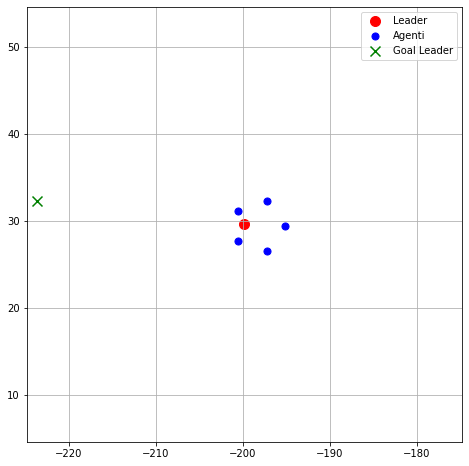

In [21]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal 
k_formation = 1.25  # Costante per mantenere la formazione

# Parametro per la velocità del goal
goal_speed = 1.5  # Velocità costante del goal ottimale: 0.5
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

view_size = 50.0  # Dimensione della finestra visibile

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione
ani = FuncAnimation(fig, update, frames=300, interval=50)  # frames=500, interval=50
ani.save(f'goal_speed_{goal_speed}.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel caso `goal_speed = 1.5` (3 volte il caso base goal_speed = 0.5), si può notare come il il sistema si posizioni a una certa distanza costante dal goal dopo una prima fase di transizione. Notare inoltre che la formazione degli agenti risulta essere leggermente decentrata rispetto al leader.

--------------

#### goal_speed = 2.0

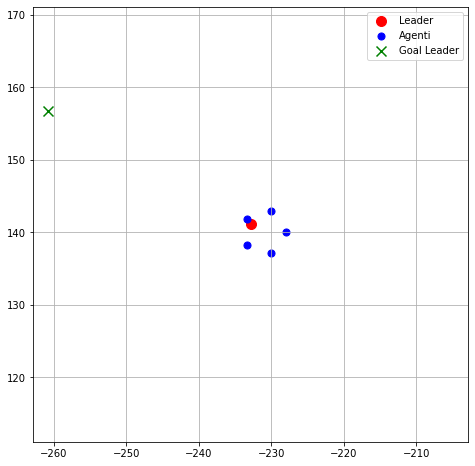

In [22]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal 
k_formation = 1.25  # Costante per mantenere la formazione

# Parametro per la velocità del goal
goal_speed = 2.0  # Velocità costante del goal ottimale: 0.5
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

view_size = 60.0  # Dimensione della finestra visibile

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione
ani = FuncAnimation(fig, update, frames=300, interval=50)  # frames=500, interval=50
ani.save(f'goal_speed_{goal_speed}.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel caso `goal_speed = 2.0` (4 volte il caso base goal_speed = 0.5), si ha un comportamento simile al precedente solo che la distanza costante tra goal e sistema risulta essere maggiore. Adesso il leader risulta essere ai bordi della formazione di agenti.

--------------

#### goal_speed = 10.0

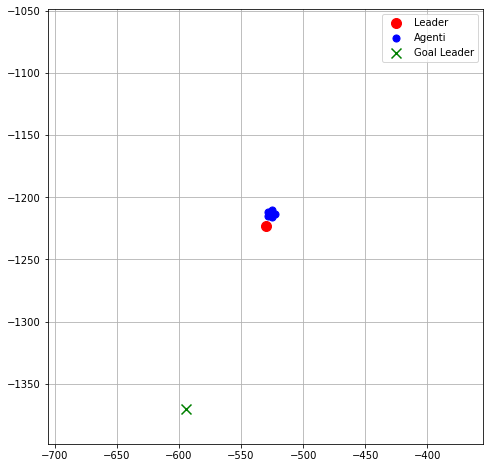

In [23]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal 
k_formation = 1.25  # Costante per mantenere la formazione

# Parametro per la velocità del goal
goal_speed = 10.0  # Velocità costante del goal ottimale: 0.5
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

view_size = 350.0  # Dimensione della finestra visibile

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione - Riusiamo il codice della funzione update definita precedentemente
ani = FuncAnimation(fig, update, frames=300, interval=50)  # frames=500, interval=50
ani.save(f'goal_speed_{goal_speed}.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel caso `goal_speed = 10.0` (20 volte il caso base goal_speed = 0.5), si ha che la distanza costante tra goal e sistema risulta essere molto maggiore rispetto a prima. Questo ci fa intuire che mantendo le stesse configurazioni delle costanti e modificando solo la velocità si ha che **al crescere della velocità costante del goal crescerà anche la distanza costante tra sistema e goal**. Inoltre si può notare come la formazione viene mantenuta correttamente ma il leader non si trova al centro di esso. Questo fa intuite che **al crescere della velocità costante del goal crescerà la distanza tra la formazione di agenti e il leader**.

--------------

#### goal_speed crescente

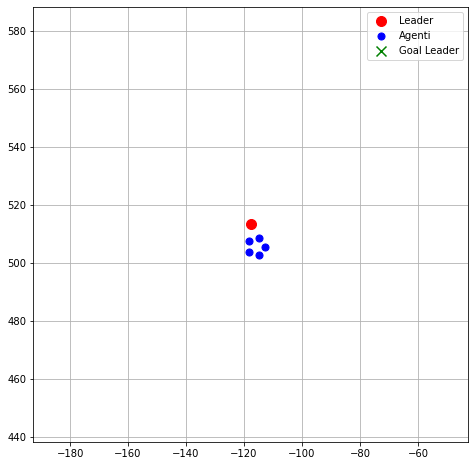

In [24]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal 
k_formation = 1.25  # Costante per mantenere la formazione

# Parametro per la velocità del goal
goal_speed = 0.5  # Velocità iniziale non può essere 0
step_increase_goal_speed = 0.025 # ci dice di quanto aumenta la velocità ad ogni passo
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

view_size = 150.0  # Dimensione della finestra visibile

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Funzione per aggiornare il sistema (leader + agenti) ad ogni frame
def update(frame):
    global leader, agents, goal_positions, goal_position, goal_velocity, goal_speed
    
    #goal_velocity = goal_velocity + step_increase_goal_speed
    # Incrementa la velocità del goal
    goal_speed += step_increase_goal_speed
    
    # Aggiorna la velocità del goal con la nuova magnitudine
    goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)

    # Movimento del leader
    force_leader = calculate_attraction_force(leader.position, goal_position, k_attraction)
    acceleration_leader = force_leader / mass
    leader.velocity = acceleration_leader * delta_time 
    leader.position += leader.velocity * delta_time

    # Movimento del goal del leader
    goal_position = move_goal(goal_position, goal_velocity)

    # Movimento degli agenti in formazione attorno al leader
    goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
    assign_goals_to_agents(agents, goal_positions)
                
    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso la posizione goal relativa
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass
            agent.velocity = acceleration * delta_time #agent.velocity += acceleration * delta_time
            agent.position += agent.velocity * delta_time

            # Controlla se l'agente ha raggiunto il goal
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)
                agent.goal_position = None

    # Aggiorna la visualizzazione
    sc_leader.set_offsets(leader.position)
    sc_agents.set_offsets([agent.position for agent in agents])
    sc_goal.set_offsets(goal_position)

    ax.set_xlim(leader.position[0] - view_size / 2, leader.position[0] + view_size / 2)
    ax.set_ylim(leader.position[1] - view_size / 2, leader.position[1] + view_size / 2)

    if np.linalg.norm(leader.position - goal_position) < epsilon_leader:
        leader.velocity = np.zeros(2)
        ani.event_source.stop()

    return sc_leader, sc_agents, sc_goal

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione 
ani = FuncAnimation(fig, update, frames=300, interval=50)  # frames=500, interval=50
ani.save(f'goal_speed_increasing.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel caso `goal_speed` cresca con il tempo (ovvero non è costante), si ha che il sistema non riuscirà a posizionarsi a una distanza costante dal goal, ma anzi sembrerà che il sistema "perda" il goal. Inoltre si può notare come la formazione di agenti sia di passo in passo sempre più distaccata dal leader.

--------------

#### goal_speed crescente + stop

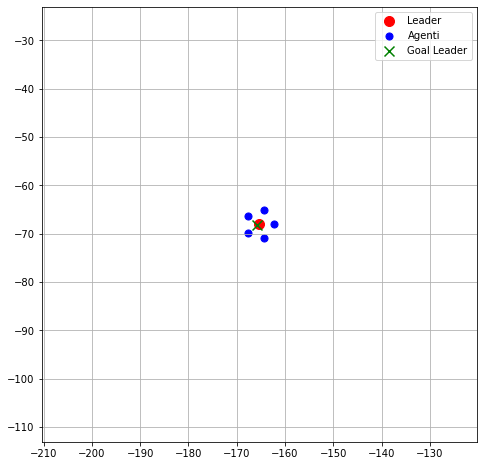

In [25]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal 
k_formation = 1.25  # Costante per mantenere la formazione

# Parametro per la velocità del goal
goal_speed = 0.5  # Velocità iniziale non può essere 0
step_increase_goal_speed = 0.025 # ci dice di quanto aumenta la velocità ad ogni passo
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

view_size = 90.0  # Dimensione della finestra visibile

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Numero totale di frame
total_frames = 300  # Stesso valore passato a FuncAnimation

# Funzione per aggiornare il sistema (leader + agenti) ad ogni frame
def update(frame):
    global leader, agents, goal_positions, goal_position, goal_velocity, goal_speed
    
    # Se siamo a metà dell'animazione, ferma il goal
    if frame > total_frames / 2:
        goal_speed = 0.0  # Ferma il goal azzerandone la velocità
        goal_velocity = np.zeros_like(goal_velocity)  # Azzerare la velocità di movimento

    # Incrementa la velocità del goal se non è fermo
    if goal_speed > 0:
        goal_speed += step_increase_goal_speed
        goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)

    # Movimento del leader
    force_leader = calculate_attraction_force(leader.position, goal_position, k_attraction)
    acceleration_leader = force_leader / mass
    leader.velocity = acceleration_leader * delta_time 
    leader.position += leader.velocity * delta_time

    # Movimento del goal del leader (solo se goal_speed > 0)
    if goal_speed > 0:
        goal_position = move_goal(goal_position, goal_velocity)

    # Movimento degli agenti in formazione attorno al leader
    goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
    assign_goals_to_agents(agents, goal_positions)
                
    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso la posizione goal relativa
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass
            agent.velocity = acceleration * delta_time
            agent.position += agent.velocity * delta_time

            # Controlla se l'agente ha raggiunto il goal
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)
                agent.goal_position = None

    # Aggiorna la visualizzazione
    sc_leader.set_offsets(leader.position)
    sc_agents.set_offsets([agent.position for agent in agents])
    sc_goal.set_offsets(goal_position)

    ax.set_xlim(leader.position[0] - view_size / 2, leader.position[0] + view_size / 2)
    ax.set_ylim(leader.position[1] - view_size / 2, leader.position[1] + view_size / 2)

    if np.linalg.norm(leader.position - goal_position) < epsilon_leader:
        leader.velocity = np.zeros(2)
        ani.event_source.stop()

    return sc_leader, sc_agents, sc_goal


# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione
ani = FuncAnimation(fig, update, frames=total_frames, interval=50)
ani.save(f'goal_speed_increasing_&_stop.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel caso `goal_speed` cresca con il tempo (ovvero non è costante) e poi si arresti, si ha che il sistema dopo una prima fase in cui cerca di seguire il goal, riuscirà a raggiungerlo una volta che esso si ferma. Gli agenti riusciranno inoltre a posizionarsi in modo corretto intorno ad esso.

--------------

#### goal_speed crescente + k crescente

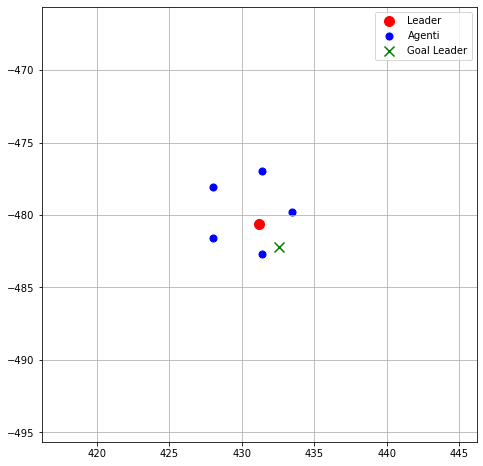

In [26]:
# Parametri del sistema
k_attraction = 0.125  # Costante per l'attrazione del leader al suo goal (k_attraction buono = 50)
k_formation = 1.25  # Costante per mantenere la formazione (k_formation forte = 100)
step_increase_k = 0.025 # ci dice di quanto aumenta la velocità ad ogni passo

# Parametro per la velocità del goal
goal_speed = 0.5  # Velocità iniziale non può essere 1
step_increase_goal_speed = 0.025 # ci dice di quanto aumenta la velocità ad ogni passo
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

view_size = 30.0  # Dimensione della finestra visibile

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Funzione per aggiornare il sistema (leader + agenti) ad ogni frame
def update(frame):
    global leader, agents, goal_positions, goal_position, goal_velocity, goal_speed
    global k_attraction, k_formation  # Aggiunte queste variabili come globali, per poterle aumentare durante update
    
    # Incrementa la velocità del goal
    goal_speed += step_increase_goal_speed
    
    # Aggiorna la velocità del goal con la nuova magnitudine
    goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)
    
    # Incrementa k_attraction e k_formation
    k_attraction += step_increase_k
    k_formation += (step_increase_k/4) #divido per 10 per mantenere il rapporto che ci deve essere tra k_attraction e k_formation
    

    # Movimento del leader
    force_leader = calculate_attraction_force(leader.position, goal_position, k_attraction)
    acceleration_leader = force_leader / mass
    leader.velocity = acceleration_leader * delta_time 
    leader.position += leader.velocity * delta_time

    # Movimento del goal del leader
    goal_position = move_goal(goal_position, goal_velocity)

    # Movimento degli agenti in formazione attorno al leader
    goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
    assign_goals_to_agents(agents, goal_positions)
                
    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso la posizione goal relativa
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass
            agent.velocity = acceleration * delta_time  # agent.velocity += acceleration * delta_time
            agent.position += agent.velocity * delta_time

            # Controlla se l'agente ha raggiunto il goal
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)
                agent.goal_position = None

    # Aggiorna la visualizzazione
    sc_leader.set_offsets(leader.position)
    sc_agents.set_offsets([agent.position for agent in agents])
    sc_goal.set_offsets(goal_position)

    ax.set_xlim(leader.position[0] - view_size / 2, leader.position[0] + view_size / 2)
    ax.set_ylim(leader.position[1] - view_size / 2, leader.position[1] + view_size / 2)

    if np.linalg.norm(leader.position - goal_position) < epsilon_leader:
        leader.velocity = np.zeros(2)
        ani.event_source.stop()

    return sc_leader, sc_agents, sc_goal

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione 
ani = FuncAnimation(fig, update, frames=300, interval=50)  # frames=500, interval=50
ani.save(f'goal_speed_&_K_increasing.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel caso `goal_speed` cresca con il tempo (ovvero non è costante) e crescano con il tempo anche `k_attraction` e `k_formation`, si ha che il leader e gli agenti riescono a seguire il goal.

**NB** Il goal_speed e il k_attraction crescono della stessa quantità, mentre il k_formation cresce di una quantità proporzionale alla crescita di k_attraction.

--------------

#### goal_speed base (0.5) + k_attraction alto (2.5)

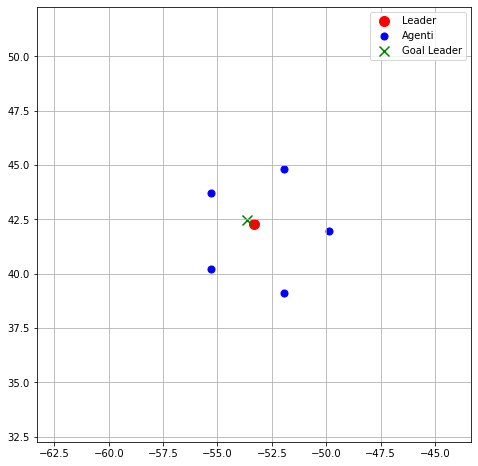

In [27]:
# Parametri del sistema
k_attraction = 2.5  # Costante per l'attrazione del leader al suo goal 
k_formation = 1.25  # Costante per mantenere la formazione 

# Parametro per la velocità del goal
goal_speed = 0.5  # Velocità costante del goal ottimale: 0.5
goal_velocity = np.random.uniform(-1, 1, size=2)  # Direzione iniziale casuale
goal_velocity = goal_speed * goal_velocity / np.linalg.norm(goal_velocity)  # Normalizza la velocità

view_size = 20.0  # Dimensione della finestra visibile

# Inizializza il leader e i suoi agenti
leader = generate_leader(leader_region_center, leader_region_size)  # Posizione iniziale del leader
agents = generate_simple_agents(num_agents, leader.position, simple_agent_std_dev)

# Genera il goal del leader
goal_position = generate_goal_position(leader.position, min_distance_from_leader, domain_size)

# Genera le posizioni goal degli agenti attorno al leader
goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
assign_goals_to_agents(agents, goal_positions)

# Funzione per aggiornare il sistema (leader + agenti) ad ogni frame
def update(frame):
    global leader, agents, goal_positions, goal_position, goal_velocity

    # Movimento del leader
    force_leader = calculate_attraction_force(leader.position, goal_position, k_attraction)
    acceleration_leader = force_leader / mass
    leader.velocity = acceleration_leader * delta_time 
    leader.position += leader.velocity * delta_time

    # Movimento del goal del leader
    goal_position = move_goal(goal_position, goal_velocity)

    # Movimento degli agenti in formazione attorno al leader
    goal_positions = distribute_agents_in_circle(leader.position, num_agents, radius)
    assign_goals_to_agents(agents, goal_positions)
                
    # Aggiorna la posizione di ogni agente
    for agent in agents:
        if agent.goal_position is not None:
            # Calcola la forza attrattiva verso la posizione goal relativa
            force = calculate_formation_force(agent.position, agent.goal_position, k_formation)
            acceleration = force / mass
            agent.velocity = acceleration * delta_time #agent.velocity += acceleration * delta_time
            agent.position += agent.velocity * delta_time

            # Controlla se l'agente ha raggiunto il goal
            if np.linalg.norm(agent.position - agent.goal_position) < epsilon_agents:
                agent.velocity = np.zeros(2)
                agent.goal_position = None

    # Aggiorna la visualizzazione
    sc_leader.set_offsets(leader.position)
    sc_agents.set_offsets([agent.position for agent in agents])
    sc_goal.set_offsets(goal_position)

    ax.set_xlim(leader.position[0] - view_size / 2, leader.position[0] + view_size / 2)
    ax.set_ylim(leader.position[1] - view_size / 2, leader.position[1] + view_size / 2)

    if np.linalg.norm(leader.position - goal_position) < epsilon_leader:
        leader.velocity = np.zeros(2)
        ani.event_source.stop()

    return sc_leader, sc_agents, sc_goal

# Visualizzazione iniziale
fig, ax = plt.subplots(figsize=(8, 8))
sc_leader = ax.scatter([leader.position[0]], [leader.position[1]], color='r', label='Leader', s=100)  # Leader
sc_agents = ax.scatter([agent.position[0] for agent in agents], [agent.position[1] for agent in agents], color='b', label='Agenti', s=50)  # Agenti
sc_goal = ax.scatter([goal_position[0]], [goal_position[1]], color='g', label='Goal Leader', s=100, marker='x')  # Goal leader

# Configura il grafico
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Animazione
ani = FuncAnimation(fig, update, frames=300, interval=50)  # frames=500, interval=50
ani.save('increasing_k_attraction.gif', dpi=100, fps=30, writer='pillow')
plt.show()

Nel caso `goal_speed` sia quello del caso base (0.5) e si aumenti solo il valore di `k_attraction` rispetto alla configurazione base, si può notare come il leader segua in modo più puntuale e preciso il goal, riducendo la distanza che si forma a regime tra essi.

**NB** notare che in questo caso il k_attraction è il doppio di k_formation.

--------------

## **<font color="purple"> Conclusioni</font>** 

Dai precedenti esperimenti si può notare che:
- Qualsiasi sia la velocità che si attribuisce al goal, si può notare che il **leader** sarà **attratto sempre nella direzione corretta**, ovvero la direzione del leader sarà sempre diretta verso il goal.  
- Con una velocità costante del goal si può notare che, dopo una fase inziale in cui il leader cerca di raggiungere il goal, la distanza tra leader e goal, diventa costante. Inoltre, **più aumenta la velocità costante del goal più aumenta la distanza costante che si frappone tra il leader e il goal** entrambi in movimento.
- Questa **distanza che il leader non riesce a colmare, varia in base alla velocità**. Per fare in modo che il leader segua esattamente il goal si può aumentare la costante k_attraction in modo proporzionale all'aumento della velocità.
- Notare inoltre che **all'aumentare della velocità del goal**, gli agenti riescono a mantenere la distanza tra di loro, ma non riescono a disporsi correttamente intorno al leader, cioè il **leader non risulta essere al centro della formazione**. Anche in questo caso, per fare in modo che la formazione degli agenti segua esattamente il leader si può aumentare la costante k_formation in modo proporzionale all'aumento della k_attraction.
- **Se la velocità del goal aumenta in modo costante allora il leader non riuscirà a raggiungere una distanza costante dal goal**, come nel caso della velocità costante. 
- Notare che **nel caso in cui il goal si arresti dopo un determinato tempo, il sistema riuscirà a raggiungere il goal e a disporsi nel modo corretto intorno ad esso**. Questo avviene sia nel caso a velocità costante che nel caso a velocità variabile.
- **In base al caso d'uso specifico da implementare** nel sistema, è **necessario trovare la configurazione di parametri ottimali** per ciò che si vuole realizzare.

In conclusione, se si ha dei `k_attraction` e `k_formation` fissi allora si può dire che aumentando la velocità costante del goal, si riesce sempre a "seguire" il goal anche se il sistema si stabilizzerà ad una certa distanza fissa. Se invece si considera un'applicazione in cui è fondamentale che questa distanza fissa non superi un determinato limite di ricezione (ad esempio, la portata massima di un trasmettitore), si può affermare che il sistema non riesce a seguire il leader ogni volta che supera questa distanza di ricezione. Per ottenere un sistema che segue meglio il goal si potrebbe allora pensare di aumentare le costanti k in proporzione a quanto viene aumentata la velocità.